In [19]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib import rc

rc("font", family="AppleGothic")
plt.rcParams["axes.unicode_minus"] = False

class bok_api():
    
    key = "RK4O8KBR4N0O4E2W6V9E"
    url_base = "http://ecos.bok.or.kr/api/"
    table = None
    stat_code = None
    data_format = {
        "DD": "%Y%m%d",
        "MM": "%Y%m",
        "YY": "%Y"
    }
    
    def __init__(self):
        self.url = self.url_base + "StatisticTableList/{}/json/kr/0/{}".format(self.key, str(1000))
        result = requests.get(self.url)
        result = pd.DataFrame(result.json()["StatisticTableList"]["row"])
        self.table = result
    
    def get_stat_list_detail(self, rows=1000, stat_code=""):
        if stat_code == "":
            raise ValueError("Stat code not provided! Please insert stat code!")
        self.url = self.url_base + "StatisticItemList/{}/json/kr/0/{}/{}".format(self.key, str(rows), stat_code)
        self.stat_code = stat_code
        result = requests.get(self.url)
        result = pd.DataFrame(result.json()["StatisticItemList"]["row"])
        self.table_detail = result
    
    def get_stat_data(self, rows=10000, start="19000101", end="30000101", item_code="", stat_code=""):
        if item_code == "":
            raise ValueError("Item code not provided! Please insert item code!")
        if stat_code != "":
            self.stat_code = stat_code
        self.item_code = item_code
        self.period = self.table_detail[self.table_detail["ITEM_CODE"] == self.item_code]["CYCLE"].values[0]
        data_format = self.data_format[self.period]
        self.url = self.url_base + "StatisticSearch/{}/json/kr/0/{}/{}/{}/{}/{}/{}".format(self.key, rows, self.stat_code, self.period, start, end, self.item_code)
        result = requests.get(self.url)
        result = pd.DataFrame(result.json()["StatisticSearch"]["row"])
        self.data = result
        self.data = self.data[["TIME", "DATA_VALUE"]]
        self.data.index = pd.to_datetime(self.data["TIME"], format=data_format)
        self.data = self.data["DATA_VALUE"].replace("", np.nan)
        return self.data
    

In [25]:
res_api = bok_api()
res_api.table[res_api.table["CYCLE"] == "DD"]
res_api.get_stat_list_detail(stat_code="060Y001")

In [48]:
res_api.table_detail
data_list = ["010101000", "010190000", "010200000", "010200001", "010210000"]
df_data = pd.DataFrame()
for x in data_list:
    df_data[x] = res_api.get_stat_data(item_code=x).astype("float64")

In [49]:
df_data_spread = df_data["010210000"] - df_data["010200000"] 

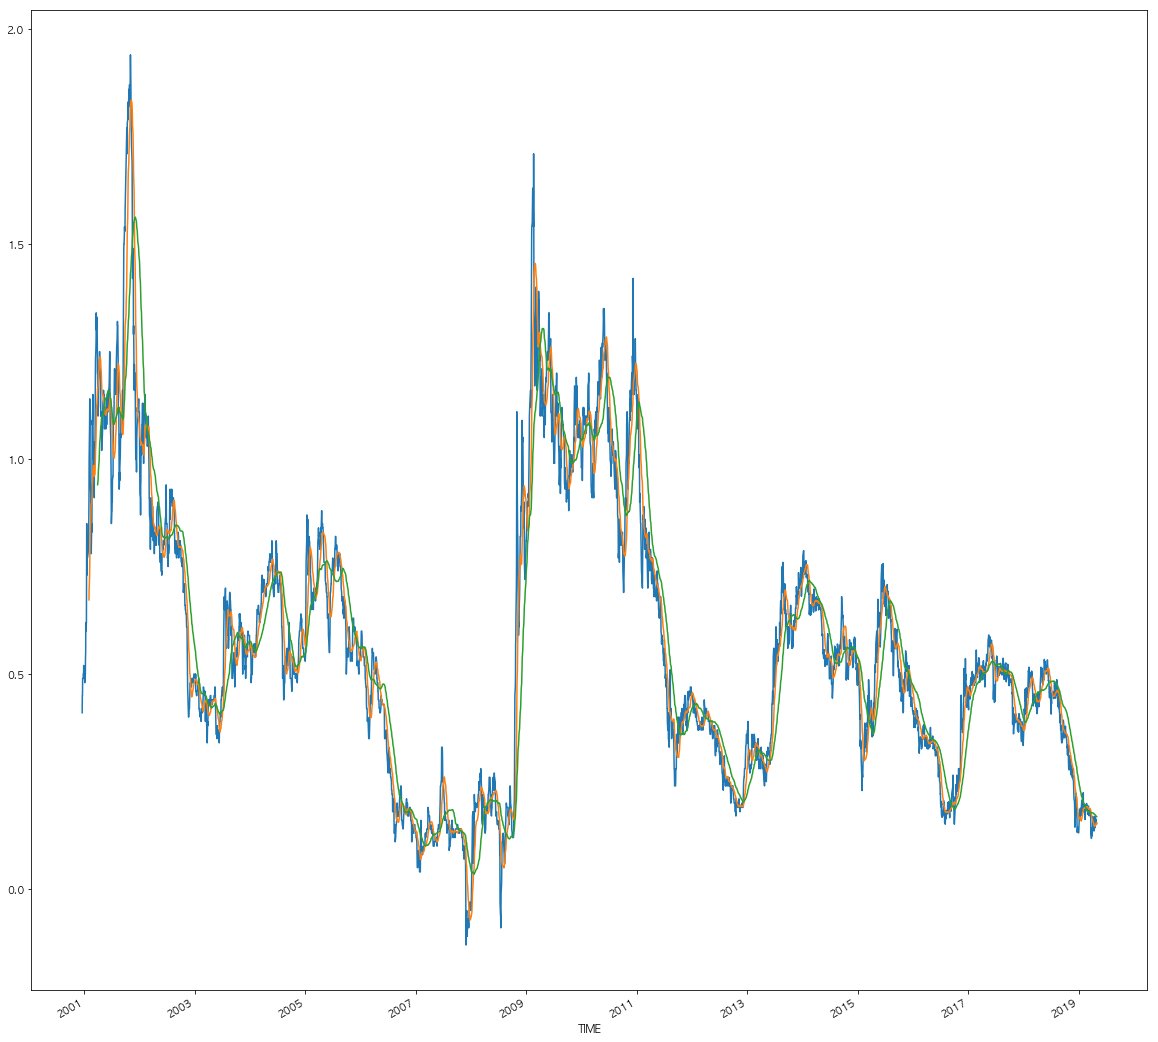

In [55]:
plt.figure(figsize=(20, 20))
df_data_spread[:].plot()
df_data_spread[:].rolling(20).mean().plot()
df_data_spread[:].rolling(60).mean().plot()

In [21]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


def to_float(element):
    if (type(element) == str) and (len(element) != 0):
        res = element.replace('\"', "")
        return float(res)
    
class krx_indus_index():
    
    base_url = "http://marketdata.krx.co.kr/contents/COM/GenerateOTP.jspx?name=fileDown&filetype=csv&url=MKD/13/1301/13010102/mkd13010102&type=2&ind_type={}&period_strt_dd={}&period_end_dd={}&pagePath=%2Fcontents%2FMKD%2F13%2F1301%2F13010102%2FMKD13010102.jsp"
    df_columns = ["date", "close", "chg", "%chg", "open", "high", "low", "vol", "vol_won", "mkt_cap"]
    
    codes_list = pd.read_csv("./krx_core/krx_index_indexno_csv.csv", header="infer")
    
    def __init__(self):
        pass
    
    def(self, start="19000101", end="30000101", index_no="5300"):
        self.url = self.base_url.format(index_no, start, end)
        response = requests.get(self.url)
        download_url = "http://file.krx.co.kr/download.jspx"
        json_data = {"code": response.content}
        headers_json = {"Referer": "http://marketdata.krx.co.kr/contents/MKD/99/MKD9900001.jspx"}
        data = requests.post(download_url, data=json_data, headers=headers_json)
        parsing = BeautifulSoup(data.text)
        parsing = parsing.text.split("\n")
        parsing = [line.replace(",", "").strip('"') for line in parsing]
        parsing = [x.split('""') for x in parsing]
        parsing = pd.DataFrame(parsing[1:], columns=self.df_columns)
        parsing.index = pd.to_datetime(parsing["date"], format="%Y/%m/%d")
        parsing.drop("date", axis=1, inplace=True)
        self.data = parsing.astype("float64")
        return self.data
    
    def get_all_index(self, start="19000101", end="30000101"):
        
        

In [1]:
from krx_index import krx_indus_index

In [12]:
test_api = krx_indus_index()

TypeError: __init__() takes 1 positional argument but 2 were given

In [61]:
kospi_list = test_api.codes_list[test_api.codes_list["index"].str.contains("코스피")]

In [62]:
kospi_list

,index,addr,index_code
20,코스피,http://marketdata.krx.co.kr/contents/COM/Gener...,1001
21,코스피 200,http://marketdata.krx.co.kr/contents/COM/Gener...,1028
22,코스피 100,http://marketdata.krx.co.kr/contents/COM/Gener...,1034
23,코스피 50,http://marketdata.krx.co.kr/contents/COM/Gener...,1035
24,코스피 제조업,http://marketdata.krx.co.kr/contents/COM/Gener...,1027
25,코스피 음식료품,http://marketdata.krx.co.kr/contents/COM/Gener...,1005
26,코스피 섬유의복,http://marketdata.krx.co.kr/contents/COM/Gener...,1006
27,코스피 종이목재,http://marketdata.krx.co.kr/contents/COM/Gener...,1007
28,코스피 화학,http://marketdata.krx.co.kr/contents/COM/Gener...,1008
29,코스피 의약품,http://marketdata.krx.co.kr/contents/COM/Gener...,1009


In [69]:
df_indices = pd.DataFrame()
for code in kospi_list["index_code"]:
    test_api.get_df_by_code(index_no=code)
    df_indices[code] = test_api.data["close"]
    print(code, " Done.")

/Users/JUSTIN/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/JUSTIN/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


1001  Done.
1028  Done.
1034  Done.
1035  Done.
1027  Done.
1005  Done.
1006  Done.
1007  Done.
1008  Done.
1009  Done.
1010  Done.
1011  Done.
1012  Done.
1013  Done.
1014  Done.
1015  Done.
1016  Done.
1017  Done.
1018  Done.
1019  Done.
1020  Done.
1021  Done.
1022  Done.
1024  Done.
1025  Done.
1026  Done.
1151  Done.
1152  Done.
1153  Done.
1154  Done.
1155  Done.
1156  Done.
1157  Done.
1158  Done.
1159  Done.
1160  Done.
1002  Done.
1003  Done.
1004  Done.


In [ ]:
def elo_rate(df, bench_mark, start_date):
    df = df.loc[start_date:]
    df_bench = df[bench_mark]
    df_update = df.drop(bench_mark)[]

In [76]:
df_ind_return = df_indices.pct_change()

In [79]:
df_ind_return.dropna(inplace=True)

In [80]:
df_indices.dropna(inplace=True)

In [91]:
df_ind_win = df_ind_return.ge(df_ind_return[1001], axis=0).astype("int8")

In [96]:
1/(1+10**((0)/400))

0.5

In [102]:
df_elo = pd.DataFrame(index=df_ind_return.index, columns=df_ind_return.columns)

In [104]:
df_elo.iloc[0] = 1500

In [105]:
df_elo
for x in range(1, df_elo.shape[0]):
    elo_series = df_elo.iloc[1]

,1001,1028,1034,1035,1027,1005,1006,1007,1008,1009,...,1154,1155,1156,1157,1158,1159,1160,1002,1003,1004
date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,...,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500
2010-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
(df_ind_return.loc["2010-07-02"] > -0.007501).sum() / df_ind_return.loc["2010-07-02"].shape[0]

0.5128205128205128

In [295]:
def get_weights(d, size):
    w = [1.]
    for k in range(1, size):
        w_=-w[-1]/k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def plot_weigths(d_range, n_plots, size):
    w = pd.DataFrame()
    for d in np.linspace(d_range[0], d_range[1], n_plots):
        w_ = get_weights(d, size=size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how="outer")
    ax = w.plot()
    ax.legend(loc="upper left")
    mpl.show()
    return


def frac_diff(series, d, thres=.01):
    w = get_weights(d, series.shape[0])
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip=w_[w_ > thres].shape[0]
    df = {}
    for name in series.columns:
        series_f, df_ = series[[name]].fillna(method="ffill").dropna(), pd.Series()
        for iloc in range(skip, series_f.shape[0]):
            loc = series_f.index[iloc]
            if not np.isfinite(series.loc[loc, name]): continue
            df[loc] = np.dot(w[-(iloc + 1):, :].T, series_f.loc[:loc])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df


def get_weights_ffd(d, thres):
    w, k = [1.], 1
    while True:
        w_ = -w[-1] / k * (d-k+1)
        if abs(w_) < thres: 
            break
        w.append(w_)
        k += 1
    w = np.array(w[::-1]).reshape(-1, 1)
    plt.plot(w)
    plt.show()
    return w


def frac_dff_ffd(series, d, thres=1e-4):
    w = get_weights_ffd(d, thres)
    width = len(w) - 1
    df = {}
    for name in series.columns:
        series_f = series[[name]].fillna(method="ffill").dropna()
        df_ = pd.Series()
        for iloc1 in range(width, series_f.shape[0]):
            loc0, loc1 = series_f.index[iloc1 - width], series_f.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]): continue
            df_[loc1] = np.dot(w.T, series_f.loc[loc0: loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df




In [296]:
test_df = pd.DataFrame([kospi["close"], kospi_200["close"]]).T
test_df.columns = ["test_1", "test_2"]

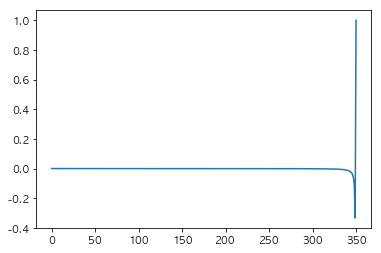

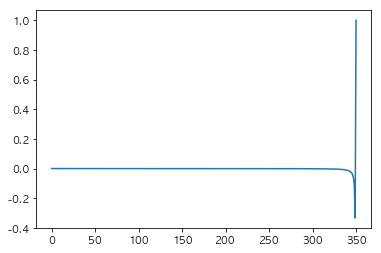

In [297]:
test_result = frac_dff_ffd(test_df, 0.333)
test_result_1 = frac_dff_ffd(test_df.loc["2010-01-01":, :], 0.333)

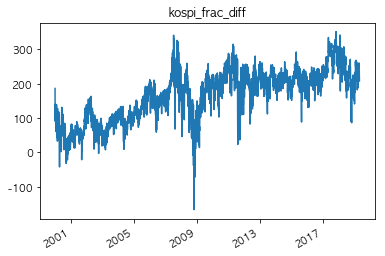

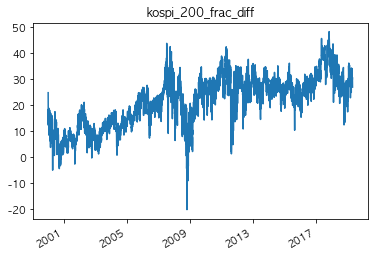

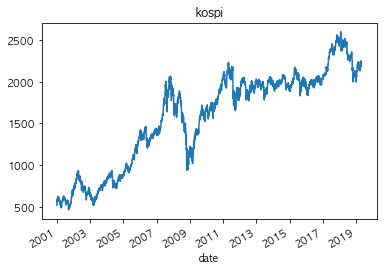

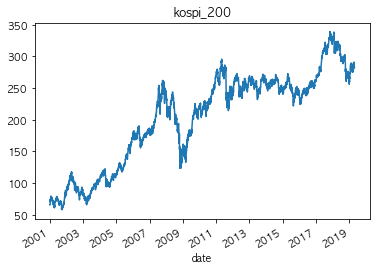

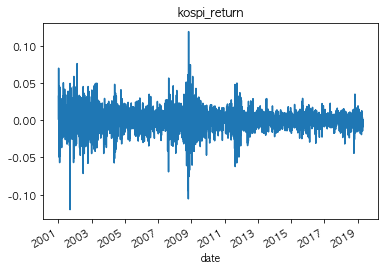

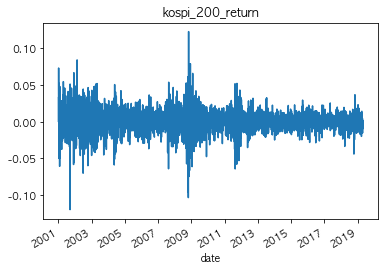

In [298]:
test_result.loc["2000-01-01":,"test_1"].plot()
plt.title("kospi_frac_diff")
plt.show()
test_result.loc["2000-01-01":,"test_2"].plot()
plt.title("kospi_200_frac_diff")
plt.show()
kospi.loc[:"2001-01-01","close"].plot()
plt.title("kospi")
plt.show()
kospi_200.loc[:"2001-01-01","close"].plot()
plt.title("kospi_200")
plt.show()
(kospi.loc[:"2001-01-01", "%chg"] / 100).plot()
plt.title("kospi_return")
plt.show()
(kospi_200.loc[:"2001-01-01", "%chg"] / 100).plot()
plt.title("kospi_200_return")
plt.show()

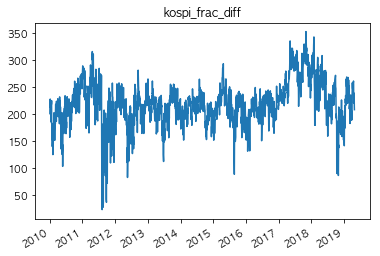

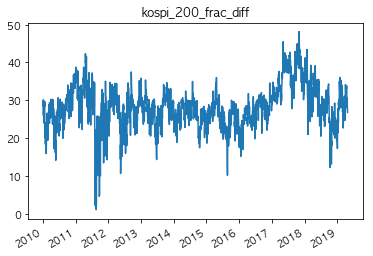

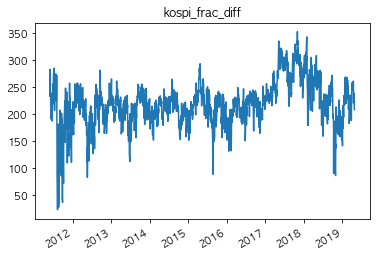

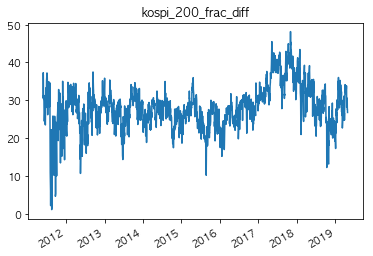

In [299]:
test_result.loc["2010-01-01":,"test_1"].plot()
plt.title("kospi_frac_diff")
plt.show()
test_result.loc["2010-01-01":,"test_2"].plot()
plt.title("kospi_200_frac_diff")
plt.show()
test_result_1.loc["2010-01-01":,"test_1"].plot()
plt.title("kospi_frac_diff")
plt.show()
test_result_1.loc["2010-01-01":,"test_2"].plot()
plt.title("kospi_200_frac_diff")
plt.show()